# Clasificación de Pacientes con Riesgo Cardiovascular usando RNS
### Por: 
### Santiago Andrés Rocha, Sebastián Rojas Bueno

---
---
## Generalidades del Proyecto:
Métricas:
* A optimizar: Exactitud - 85%
* A satisfacer: Tiempo - 20 min

Pérdida:
* Loss: Binary Crossentropy



## Manejo de datos, uso de Dataset "Heart Attack Analysis & Prediction Dataset" 
https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

In [1]:
#Importaciones necesarias para la realización del laboratorio
import numpy as np
import math
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

#Red Neuronal con Keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras

#Directamente para el modelo
#from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense



### Visualización de los Datos

In [2]:
def contador(datos, ejeX, ejeY, titulo):
  count = {}
  for elemento in datos:
      if elemento in count:
          count[elemento] += 1
      else:
          count[elemento] = 1

  elementos = list(count.keys())
  repeticiones = list(count.values())

  # Graficar
  plt.bar(elementos, repeticiones)
  plt.xlabel(ejeX)
  plt.ylabel(ejeY)
  plt.title(titulo)

  for i in range(len(elementos)):
      plt.text(elementos[i], repeticiones[i], repeticiones[i], ha='center', va='bottom')
    
  plt.show()


def prepara(archivo):
  filename = archivo
  data = pd.read_csv(filename, header=0, encoding='latin-1')

  print(data.shape)
  print(data.head(11))

  print(data.describe())
  return data

def graficaOutput(data):

  output = data['output']
  contador(output, 'Resultados Posibles', 'Repeticiones', 'Resultados y su Distribución')

def graficaEdad(data):
  ages = []
  try:
      ages = data['age']
      agesTag = 'age'
  except:
      ages = data['ï»¿age']
      agesTag = 'ï»¿age'
  finally:
      contador(ages, 'Edades', 'Repeticiones', 'Edades y su Distribución')

  print(data[[agesTag, 'output']])

## Selección del Dataset

In [3]:
data = prepara('heart2.csv')

(303, 14)
    ï»¿age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0       63    1   3       145   233    1        0      150      0      2.3   
1       56    1   2       130   256    1        0      142      1      0.6   
2       37    1   2       130   250    0        1      187      0      3.5   
3       48    1   1       110   229    0        1      168      0      1.0   
4       41    0   1       130   204    0        0      172      0      1.4   
5       58    1   1       120   284    0        0      160      0      1.8   
6       56    1   1       120   236    0        1      178      0      0.8   
7       58    1   2       132   224    0        0      173      0      3.2   
8       57    0   0       120   354    0        1      163      1      0.6   
9       60    1   0       130   206    0        0      132      1      2.4   
10      57    1   0       140   192    0        1      148      0      0.4   

    slope  ca  thal  output  
0       0   0     1    

Así:
* Edad mínima: 29 años
* Edad máxima: 77 años

#### Distribución de los datos

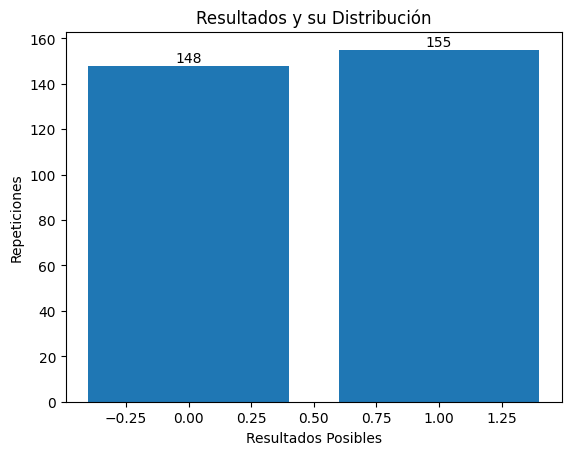

In [4]:
graficaOutput(data)

#### Edades y sus frecuencias

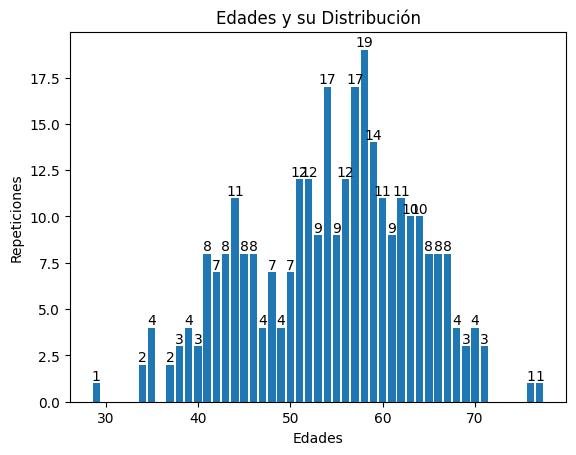

     ï»¿age  output
0        63       1
1        56       0
2        37       1
3        48       0
4        41       1
..      ...     ...
298      62       0
299      38       1
300      67       0
301      38       1
302      67       0

[303 rows x 2 columns]


In [5]:
graficaEdad(data)

Con esta gráfica, vemos que el mayor número de registros por edad corresponde a 
* 58 años, con 19 registros.

Por otro lado, el menor número de registro se tiene para las edades:
* 29, 74, 76 y 77 años con 1 registro.
* 30, 31, 32, 33, 36, 72, 73, 75 años con 0 registros.

Como podemos ver, no hay aparente relación entre la edad y la propensión a sufrir ataques cardíacos. Es por esto que más adelante normalizaremos toda columna del dataset, incluyendo por su puesto las edades.

### Preprocesamiento de los datos
Tomamos todas las columnas de la tabla, y eliminamos las filas que no posean datos o que tengan algún espacio vacío

In [6]:
data = data.dropna()
data

,ï»¿age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,56,1,2,130,256,1,0,142,1,0.6,1,1,1,0
2,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
3,48,1,1,110,229,0,1,168,0,1.0,0,0,3,0
4,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,62,0,0,140,268,0,0,160,0,3.6,0,2,2,0
299,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
300,67,1,0,120,229,0,0,129,1,2.6,1,2,3,0
301,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


#### Normalización (MinMax)

In [7]:
data_normalized = (data - data.min()) / (data.max() - data.min())

### Distribución de datos
* Con cuantos años de inflación predecimos cuántos años?
    * Con las 13 columnas de síntomas y características, 
    clasificamos si es propenso a un ataque al corazón o no.
    
| Datos | % | Filas del Dataset |
|:---------:|:---------:|:---------:|
| Entrenamiento | 60% | 182 |
| Validación | 30% | 91 |
| Test | 10% | 30 |

In [8]:
# Separación de los datos según su función

def separaDatos(data):# Entrenamiento 
  heartTrain = data.iloc[:182,:].copy()
  xTrain = heartTrain.iloc[:, :13]
  yTrain = heartTrain.iloc[:, 13:14]

  # Validación
  heartVal = data.iloc[182:273,:].copy()
  xValid = heartVal.iloc[:, :13]
  yValid = heartVal.iloc[:, 13:14]

  # Test
  heartTest = data.iloc[273:303,:].copy()
  xTest = heartTest.iloc[:, :13]
  yTest = heartTest.iloc[:, 13:14]

  return [xTrain, yTrain, xValid, yValid, xTest, yTest]

########################
#  Datos originales  #
########################
[xTrain, yTrain, xValid, yValid, xTest, yTest] = separaDatos(data)

########################
#  Datos Normalizados  #
########################
[xTrain_normalized,
 yTrain_normalized,
 xValid_normalized,
 yValid_normalized,
 xTest_normalized,
 yTest_normalized] = separaDatos(data_normalized)

print(xTrain)
print(xTrain_normalized)


     ï»¿age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0        63    1   3       145   233    1        0      150      0      2.3   
1        56    1   2       130   256    1        0      142      1      0.6   
2        37    1   2       130   250    0        1      187      0      3.5   
3        48    1   1       110   229    0        1      168      0      1.0   
4        41    0   1       130   204    0        0      172      0      1.4   
..      ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
177      58    0   0       100   248    0        0      122      0      1.0   
178      67    1   0       120   237    0        1       71      0      1.0   
179      48    1   2       124   255    1        1      175      0      0.0   
180      52    1   0       128   204    1        1      156      1      1.0   
181      57    1   0       132   207    0        1      168      1      0.0   

     slope  ca  thal  
0        0   0     1  
1    

#### Datos de Entrenamiento

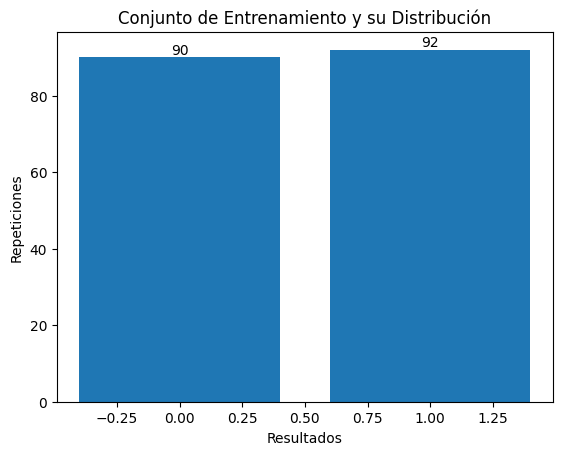

In [9]:
#yTrain
contador(yTrain['output'], 'Resultados', 'Repeticiones', 'Conjunto de Entrenamiento y su Distribución')

#### Datos de Validación

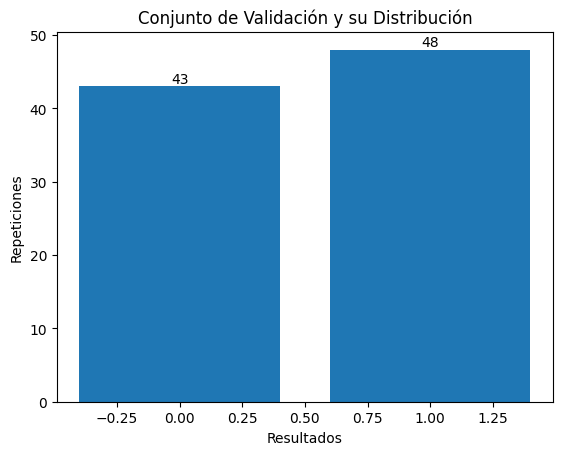

In [10]:
#yValid
contador(yValid['output'], 'Resultados', 'Repeticiones', 'Conjunto de Validación y su Distribución')

#### Datos de Prueba

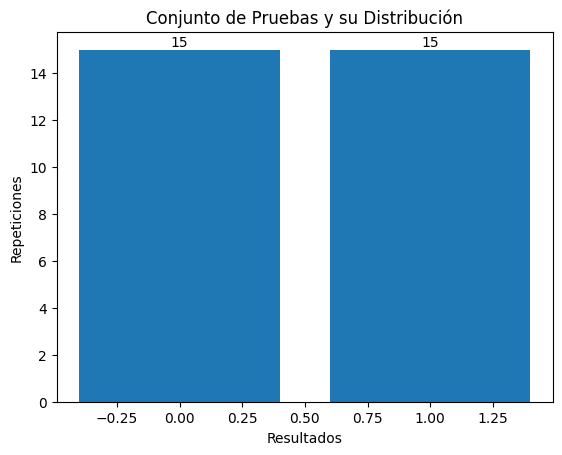

In [11]:
#yTest
contador(yTest['output'], 'Resultados', 'Repeticiones', 'Conjunto de Pruebas y su Distribución')

## Métodos que nos ayudarán a construir y evaluar varios modelos

In [12]:
def compilaModelo(modelo, xTrain, yTrain, xValid, yValid, imprime):
  # Compilamos el modelo, con función de Costo de
  #Cross Entropy, optimizador 'adam' 
  # y con métrica de Exactitud

  #Adam, para aprender pesos y sesgos de forma eficiente

  modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Entrenamiento y Validación
  history = modelo.fit(xTrain, yTrain, epochs=500, validation_data=(xValid, yValid), verbose = imprime)
  print("Entrenamiento completado!")
  return modelo, history

def evaluaEntrena(history):
  # Evaluación
  fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
  ax1[0].plot(history.history['accuracy'], label='Training Accuracy')
  ax1[0].set_xlabel('Epoch')
  ax1[0].set_ylabel('Accuracy')
  ax1[0].legend()

  ax1[1].plot(history.history['loss'], label='Training Loss')
  ax1[1].set_xlabel('Epoch')
  ax1[1].set_ylabel('Loss')
  ax1[1].legend()

def defxValyTest(yTest):
  xVal = []
  for i in range(273, 303):
    xVal.append(i)
  yTestArr = np.array(yTest)

  return xVal, yTestArr

def evaluaPrueba(testResult, yTest):
  xVal, yTestArr = defxValyTest(yTest)

  fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
  ax1.scatter(xVal, yTestArr, label='Resultados Reales')
  ax1.set_xlabel('Caso')
  ax1.set_ylabel('Resultado')
  ax1.legend()

  ax1.scatter(xVal, testResult, label='Resultados del Test')
  ax1.set_xlabel('Caso')
  ax1.set_ylabel('Resultado')
  ax1.legend()
  return xVal

def pruebaModelo(modelo, xTest, yTest):
  testResult = modelo.predict(xTest, verbose=False)
  evaluaPrueba(testResult, yTest)

  return testResult

def ajustaTest(testResult):
  xVal, yTestArr = defxValyTest(yTest)
  testResultAdjust = []
  for result in testResult:
    if result > 0.65:
      testResultAdjust.append(1)
    else:
      testResultAdjust.append(0)
  fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
  ax1.scatter(xVal, yTestArr, label='Resultados Reales')
  ax1.set_xlabel('Caso')
  ax1.set_ylabel('Resultado')
  ax1.legend()

  ax1.scatter(xVal, testResultAdjust, label='Resultados del Test')
  ax1.set_xlabel('Caso')
  ax1.set_ylabel('Resultado')
  ax1.legend()

  return testResultAdjust

def exactitudTest(testResultAdjust, yTestArr):
  obtenido = testResultAdjust
  esperado = np.transpose(yTestArr)
  esperado = list(esperado[0])

  count = 0
  for i in range(len(esperado)):
    if obtenido[i] == esperado[i]:
      count += 1
  
  exactitud = count / len(esperado)
  
  return exactitud


def matConf(testResultAdjust):
  xVal, yTestArr = defxValyTest(yTest)
  matriz_confusion = confusion_matrix(yTestArr, testResultAdjust)
  exactitudPrueba = exactitudTest(testResultAdjust, yTestArr)

  # Crear gráfico de calor para la matriz de confusión
  plt.imshow(matriz_confusion, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()
  plt.xlabel('Etiqueta Predicha')
  plt.ylabel('Etiqueta Verdadera')
  plt.xticks(np.arange(len(np.unique(yTestArr))), np.unique(yTestArr))
  plt.yticks(np.arange(len(np.unique(yTestArr))), np.unique(yTestArr))

  # Anotar los valores en cada celda
  for i in range(matriz_confusion.shape[0]):
      for j in range(matriz_confusion.shape[1]):
          plt.text(j, i, str(matriz_confusion[i, j]), ha='center', va='center', color='black')

  plt.title('Matriz de Confusión')
  plt.show()
  return exactitudPrueba

def resultados(history, exactitud):
  print("###### Resultados en Entrenamiento ######")
  print("Pérdida:")
  print(str(round(history.history['loss'][-1],3)))
  print("Exactitud:")
  print(str(round(history.history['accuracy'][-1]*100,3)) + "%")

  print("\n###### Resultados en Validación ######")
  print("Exactitud:")
  print(str(round(history.history['val_accuracy'][-1]*100,3)) + "%")

  print("\n###### Resultados en Pruebas ######")
  print("Exactitud:")
  print(str(round(exactitud*100,3)) + "%")


---
---
## Primer Modelo
* Perceptrón

In [13]:
# Entrada-Salida
salida = Dense(units=1, input_shape=[13], activation='sigmoid')
primerModelo = Sequential([salida])

Entrenamiento completado!


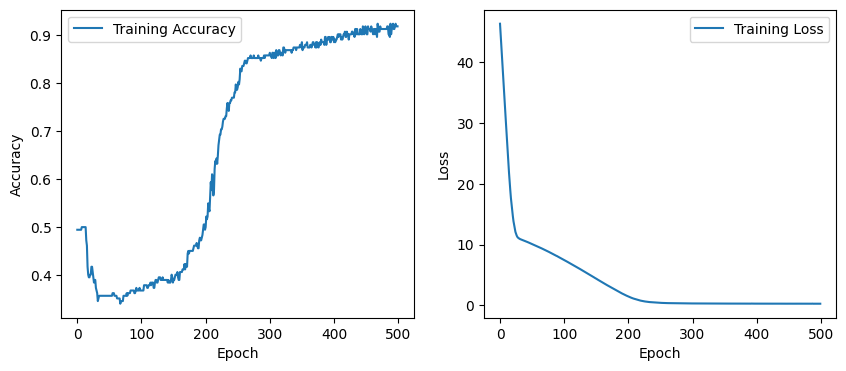

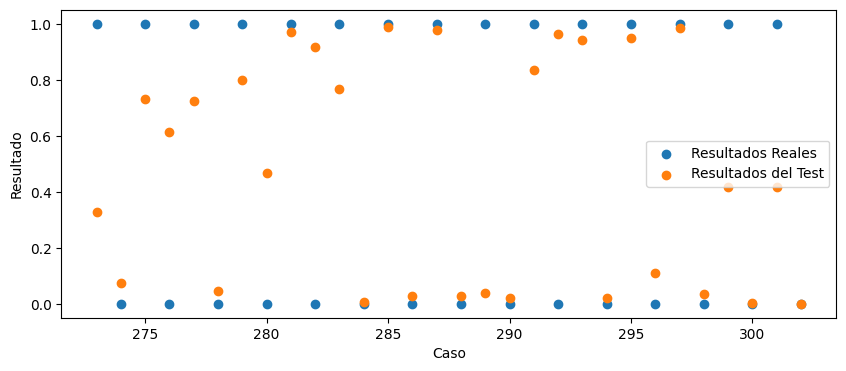

In [14]:
modelo, history = compilaModelo(primerModelo, xTrain, yTrain, xValid, yValid, False)
evaluaEntrena(history)
resultadoTest = pruebaModelo(modelo, xTest, yTest)

#### Análisis de datos: ¿Probabilidad de Sufrir?
Si los resultados sobrepasan el 65%, diremos que SI son propensos a sufrir ataques cardíacos. De lo contario, diremos que NO son propensos.


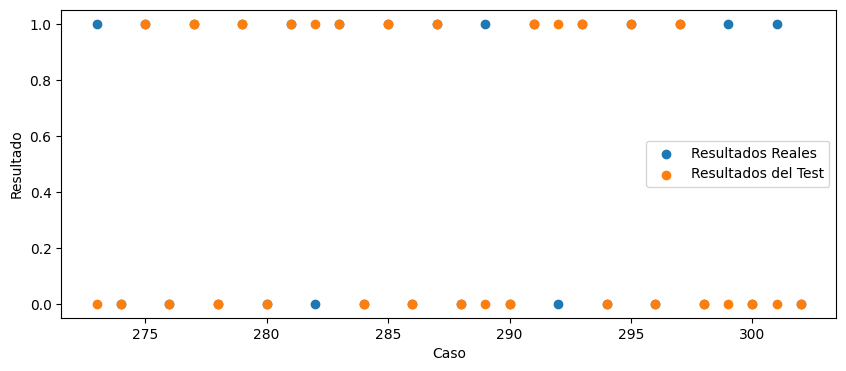

In [15]:
testResultAdjust = ajustaTest(resultadoTest)

Visualizando resultados con una matriz de confusión:

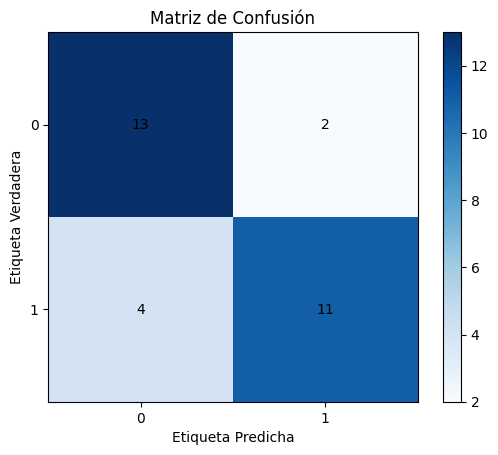

In [16]:
exactitudPrueba = matConf(testResultAdjust)

### Resumen de los Resultados
* Resumen del modelo:

In [17]:
primerModelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [18]:
resultados(history, exactitudPrueba)

###### Resultados en Entrenamiento ######
Pérdida:
0.273
Exactitud:
91.758%

###### Resultados en Validación ######
Exactitud:
69.231%

###### Resultados en Pruebas ######
Exactitud:
80.0%


---
---
## Segundo Modelo
* 2 capas ocultas
* relu

In [19]:
# Entrada-Ocultas
oculta1 = Dense(units=9, input_shape=[13], activation='relu')
oculta2 = Dense(5, activation='relu')
# Salida
salida = Dense(units=1, activation='sigmoid')

segundoModelo = Sequential([oculta1, oculta2, salida])

Entrenamiento completado!


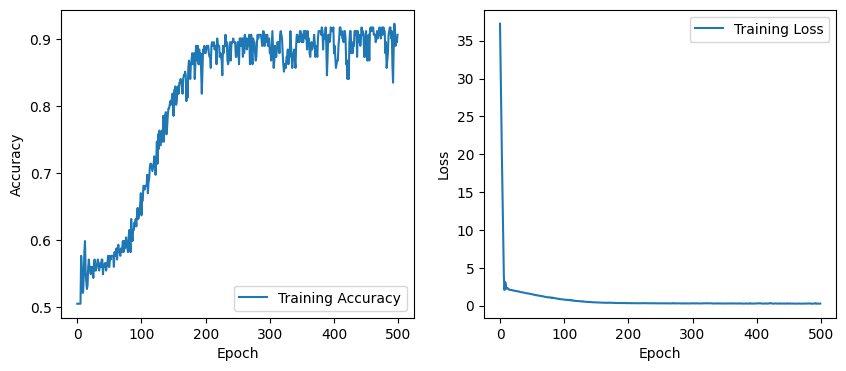

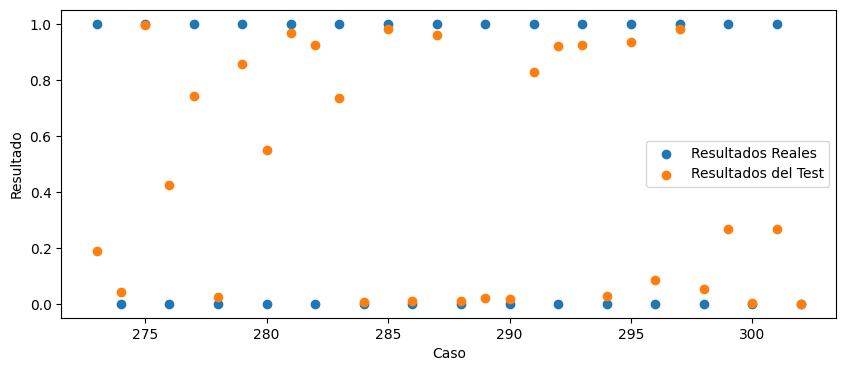

In [20]:
modelo, history = compilaModelo(segundoModelo, xTrain, yTrain, xValid, yValid, False)
evaluaEntrena(history)
resultadoTest = pruebaModelo(modelo, xTest, yTest)

#### Análisis de datos: ¿Probabilidad de Sufrir?
Si los resultados sobrepasan el 65%, diremos que SI son propensos a sufrir ataques cardíacos. De lo contario, diremos que NO son propensos.


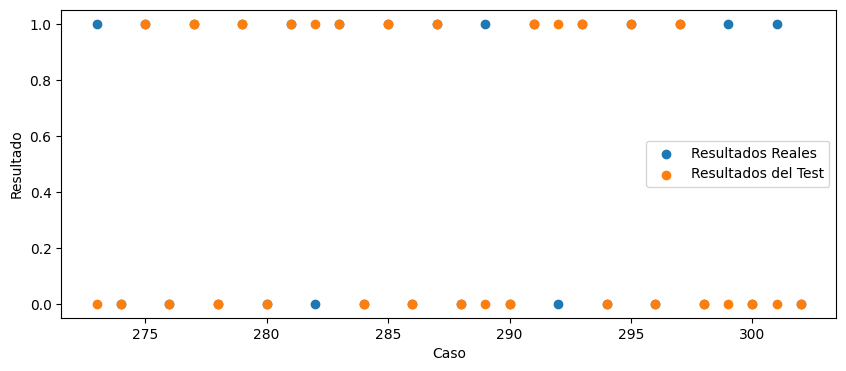

In [21]:
testResultAdjust = ajustaTest(resultadoTest)

Visualizando resultados con una matriz de confusión:

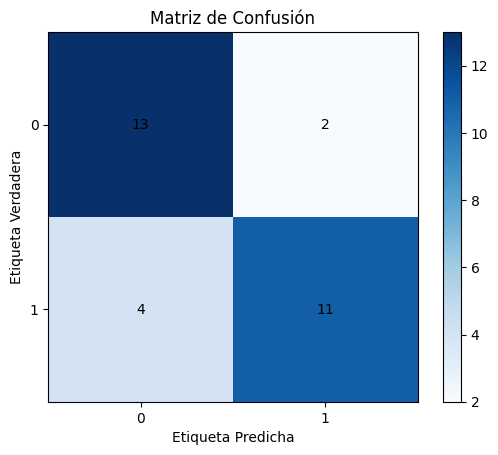

In [22]:
exactitudPrueba = matConf(testResultAdjust)

### Resumen de los Resultados
* Resumen del modelo:

In [23]:
segundoModelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 9)                 126       
                                                                 
 dense_2 (Dense)             (None, 5)                 50        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________


In [24]:
resultados(history, exactitudPrueba)

###### Resultados en Entrenamiento ######
Pérdida:
0.277
Exactitud:
90.659%

###### Resultados en Validación ######
Exactitud:
73.626%

###### Resultados en Pruebas ######
Exactitud:
80.0%


---
---
## Tercer Modelo
* 4 capas ocultas
* relu

In [25]:
# Entrada-Ocultas
oculta1 = Dense(units=11, input_shape=[13], activation='relu')
oculta2 = Dense(9, activation='relu')
oculta3 = Dense(5, activation='relu')
oculta4 = Dense(3, activation='relu')
# Salida
salida = Dense(1, activation='sigmoid')

tercerModelo = Sequential([oculta1, oculta2, oculta3, oculta4, salida])

Entrenamiento completado!


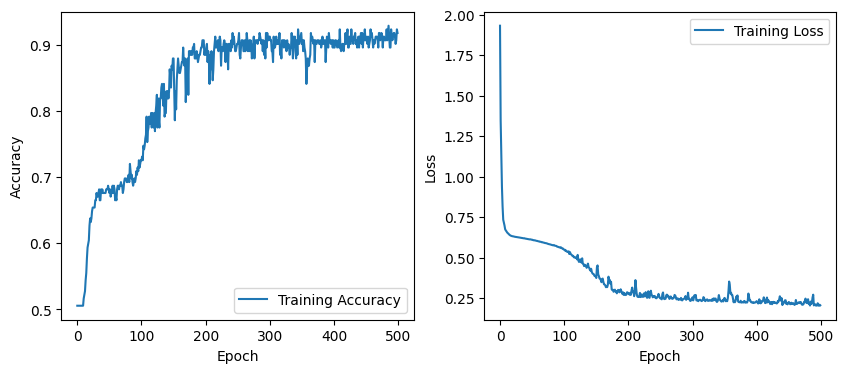

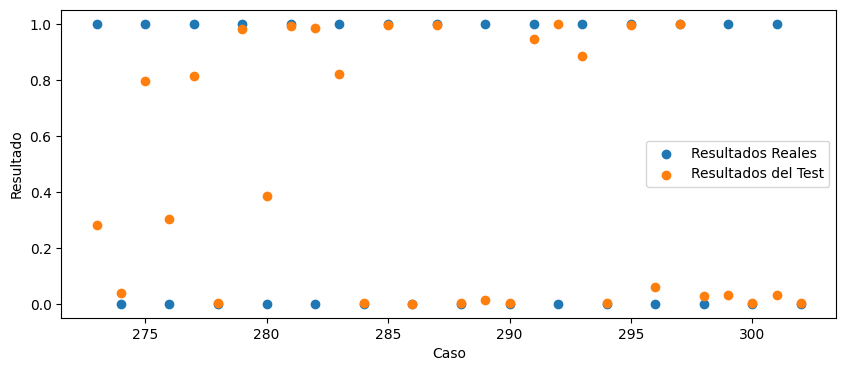

In [26]:
modelo, history = compilaModelo(tercerModelo, xTrain, yTrain, xValid, yValid, False)
evaluaEntrena(history)
resultadoTest = pruebaModelo(modelo, xTest, yTest)

#### Análisis de datos: ¿Probabilidad de Sufrir?
Si los resultados sobrepasan el 65%, diremos que SI son propensos a sufrir ataques cardíacos. De lo contario, diremos que NO son propensos.


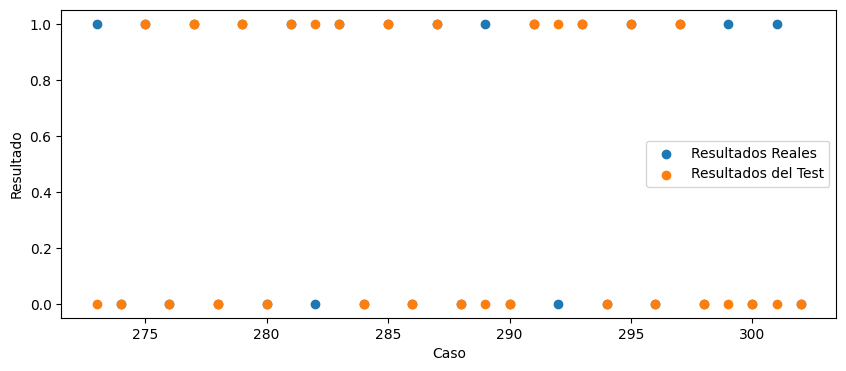

In [27]:
testResultAdjust = ajustaTest(resultadoTest)

Visualizando resultados con una matriz de confusión:

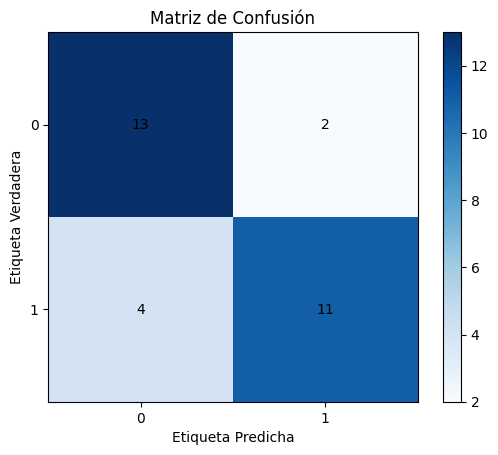

In [28]:
exactitudPrueba =matConf(testResultAdjust)

### Resumen de los Resultados
* Resumen del modelo:

In [29]:
tercerModelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 11)                154       
                                                                 
 dense_5 (Dense)             (None, 9)                 108       
                                                                 
 dense_6 (Dense)             (None, 5)                 50        
                                                                 
 dense_7 (Dense)             (None, 3)                 18        
                                                                 
 dense_8 (Dense)             (None, 1)                 4         
                                                                 
Total params: 334
Trainable params: 334
Non-trainable params: 0
_________________________________________________________________


In [30]:
resultados(history, exactitudPrueba)

###### Resultados en Entrenamiento ######
Pérdida:
0.207
Exactitud:
91.758%

###### Resultados en Validación ######
Exactitud:
70.33%

###### Resultados en Pruebas ######
Exactitud:
80.0%


---
---
## Cuarto Modelo
* 6 capas ocultas
* relu


In [31]:
# Entrada-Ocultas
oculta1 = Dense(units=11, input_shape=[13], activation='relu')
oculta2 = Dense(13, activation='relu')
oculta3 = Dense(13, activation='relu')
oculta4 = Dense(13, activation='relu')
oculta5 = Dense(11, activation='relu')
oculta6 = Dense(3, activation='relu')
#Salida
salida = Dense(1, activation='sigmoid')

cuartoModelo = Sequential([oculta1, oculta2, oculta3, oculta4, oculta5, oculta6, salida])

In [32]:
modelo, history = compilaModelo(cuartoModelo, xTrain, yTrain, xValid, yValid, False)

Entrenamiento completado!


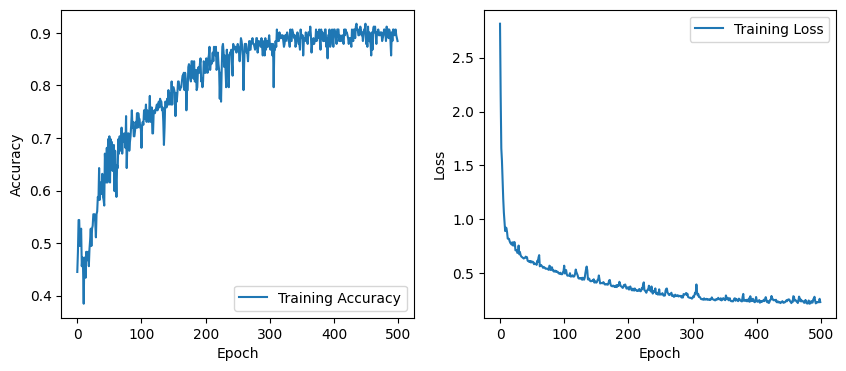

In [33]:
evaluaEntrena(history)

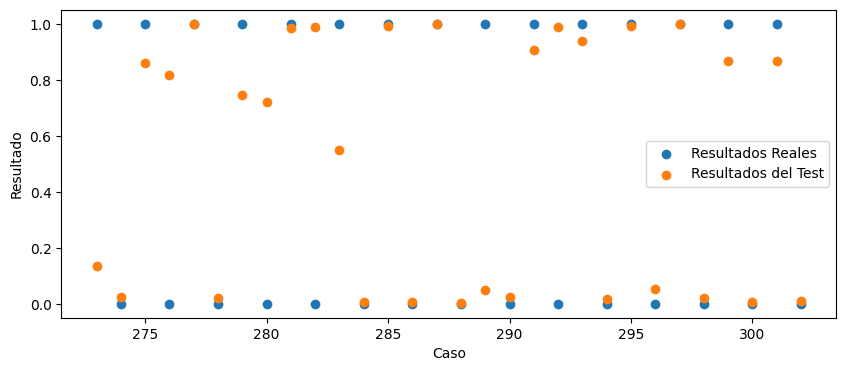

In [34]:
resultadoTest = pruebaModelo(modelo, xTest, yTest)

#### Análisis de datos: ¿Probabilidad de Sufrir?
Si los resultados sobrepasan el 65%, diremos que SI son propensos a sufrir ataques cardíacos. De lo contario, diremos que NO son propensos.


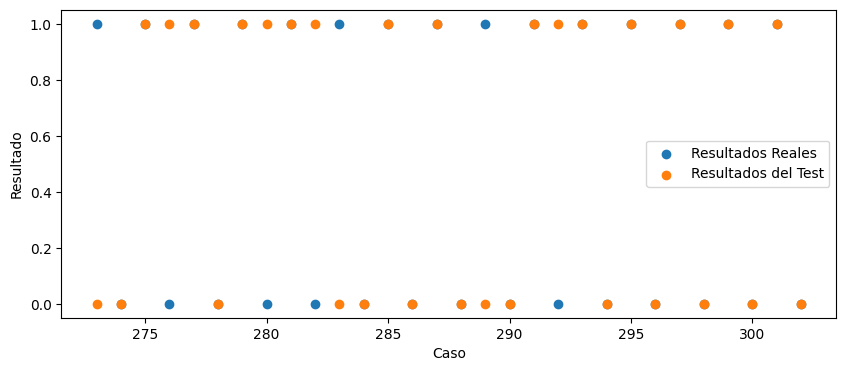

In [35]:
testResultAdjust = ajustaTest(resultadoTest)

Visualizando resultados con una matriz de confusión:

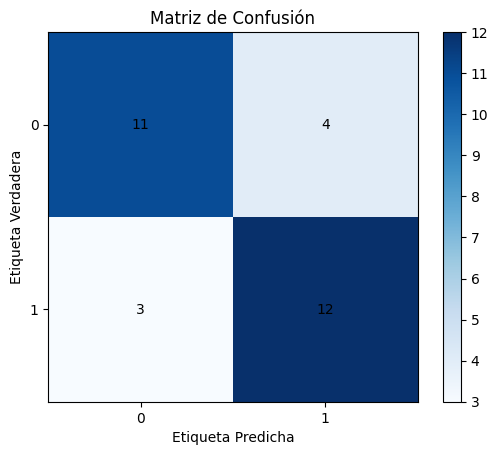

In [36]:
exactitudPrueba = matConf(testResultAdjust)

### Resumen de los Resultados
* Resumen del modelo:

In [37]:
cuartoModelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 11)                154       
                                                                 
 dense_10 (Dense)            (None, 13)                156       
                                                                 
 dense_11 (Dense)            (None, 13)                182       
                                                                 
 dense_12 (Dense)            (None, 13)                182       
                                                                 
 dense_13 (Dense)            (None, 11)                154       
                                                                 
 dense_14 (Dense)            (None, 3)                 36        
                                                                 
 dense_15 (Dense)            (None, 1)                

In [38]:
resultados(history, exactitudPrueba)

###### Resultados en Entrenamiento ######
Pérdida:
0.234
Exactitud:
88.462%

###### Resultados en Validación ######
Exactitud:
71.429%

###### Resultados en Pruebas ######
Exactitud:
76.667%


---
# Modelos con los datos Normalizados

---
## Primer Modelo
* Perceptrón

Entrenamiento completado!


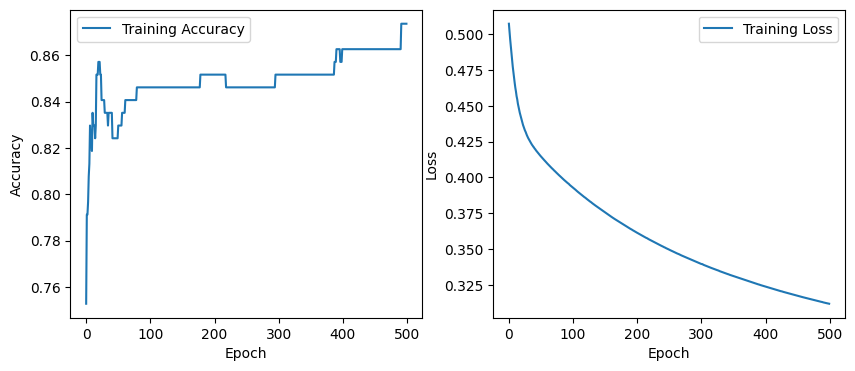

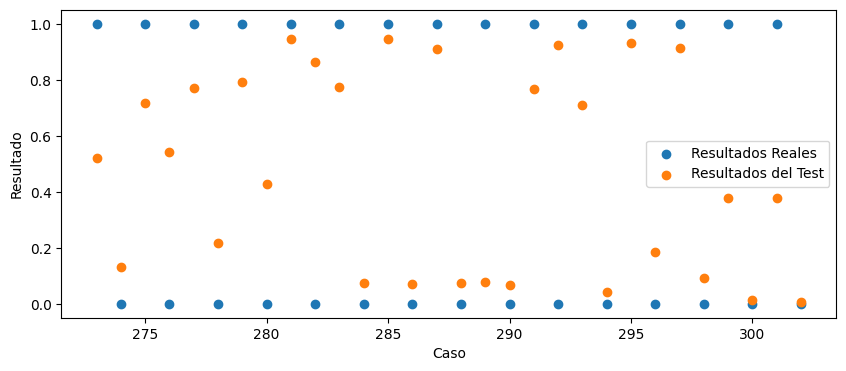

In [39]:
modelo, history = compilaModelo(primerModelo, xTrain_normalized, yTrain_normalized, xValid_normalized, yValid_normalized, False)
evaluaEntrena(history)
resultadoTest = pruebaModelo(modelo, xTest_normalized, yTest_normalized)

#### Análisis de datos: ¿Probabilidad de Sufrir?
Si los resultados sobrepasan el 65%, diremos que SI son propensos a sufrir ataques cardíacos. De lo contario, diremos que NO son propensos.


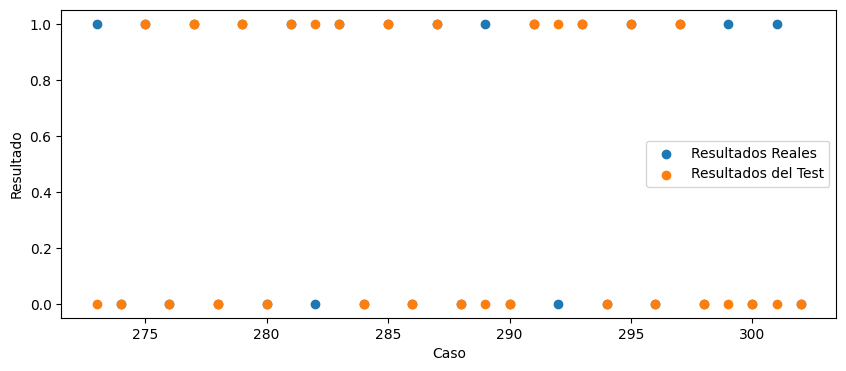

In [40]:
testResultAdjust = ajustaTest(resultadoTest)

Visualizando resultados con una matriz de confusión:

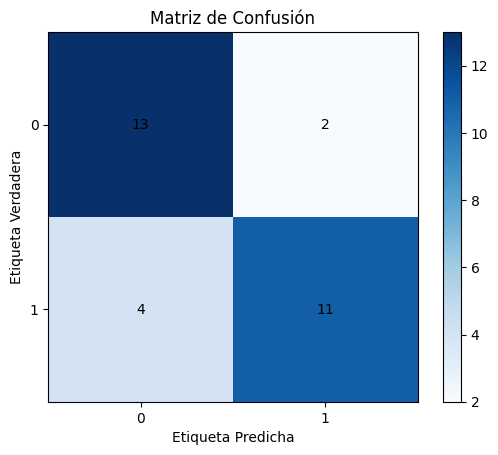

In [41]:
exactitudPrueba = matConf(testResultAdjust)

### Resumen de los Resultados

In [42]:
resultados(history, exactitudPrueba)

###### Resultados en Entrenamiento ######
Pérdida:
0.312
Exactitud:
87.363%

###### Resultados en Validación ######
Exactitud:
71.429%

###### Resultados en Pruebas ######
Exactitud:
80.0%


---
## Segundo Modelo
* 2 capas ocultas
* relu

Entrenamiento completado!


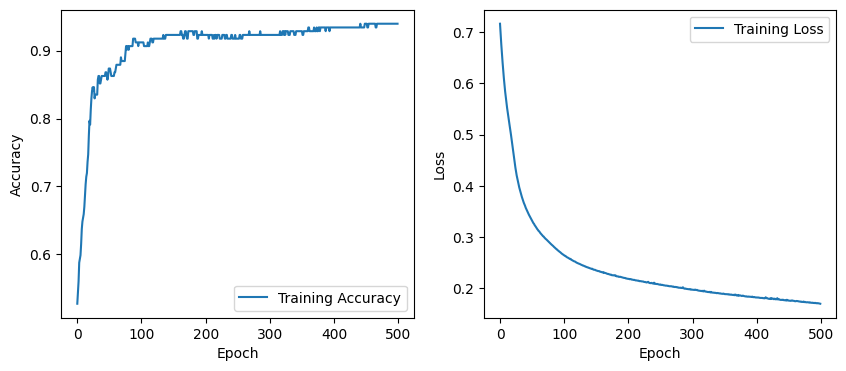

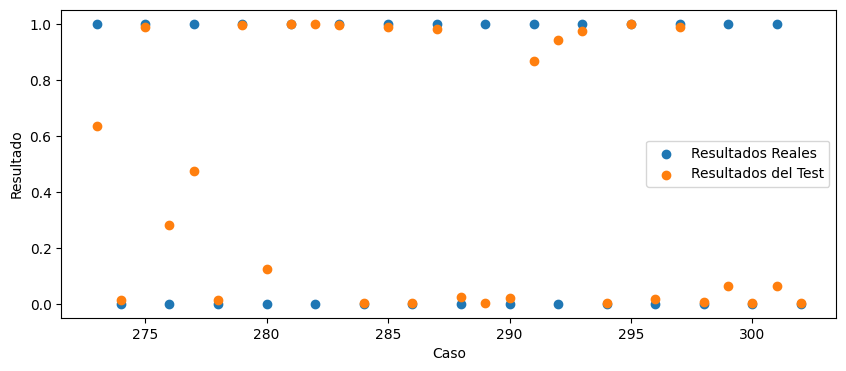

In [43]:
modelo, history = compilaModelo(segundoModelo, xTrain_normalized, yTrain_normalized, xValid_normalized, yValid_normalized, False)
evaluaEntrena(history)
resultadoTest = pruebaModelo(modelo, xTest_normalized, yTest_normalized)

#### Análisis de datos: ¿Probabilidad de Sufrir?
Si los resultados sobrepasan el 65%, diremos que SI son propensos a sufrir ataques cardíacos. De lo contario, diremos que NO son propensos.


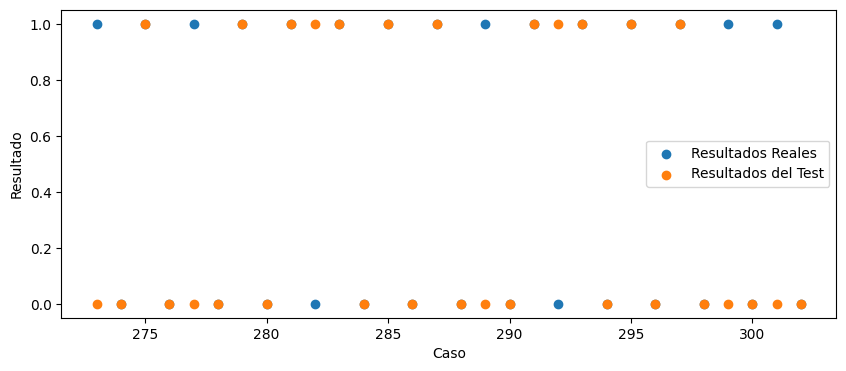

In [44]:
testResultAdjust = ajustaTest(resultadoTest)

Visualizando resultados con una matriz de confusión:

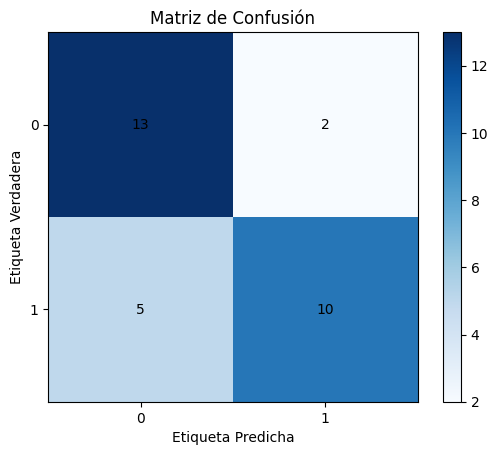

In [45]:
exactitudPrueba = matConf(testResultAdjust)

### Resumen de los Resultados

In [46]:
resultados(history, exactitudPrueba)

###### Resultados en Entrenamiento ######
Pérdida:
0.17
Exactitud:
93.956%

###### Resultados en Validación ######
Exactitud:
72.527%

###### Resultados en Pruebas ######
Exactitud:
76.667%


---
## Tercer Modelo
* 4 capas ocultas
* relu

Entrenamiento completado!


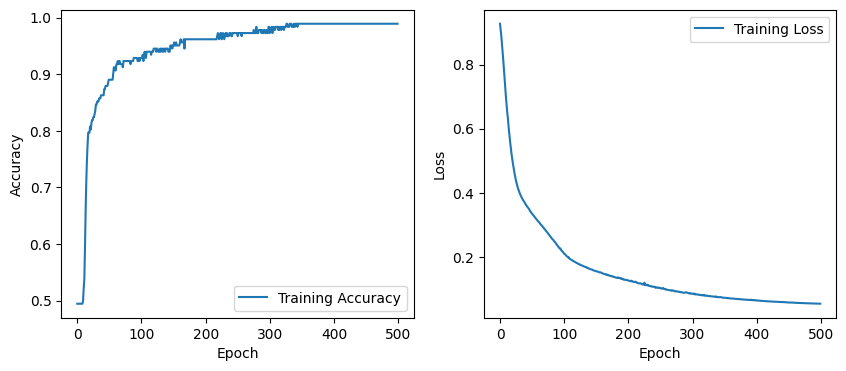

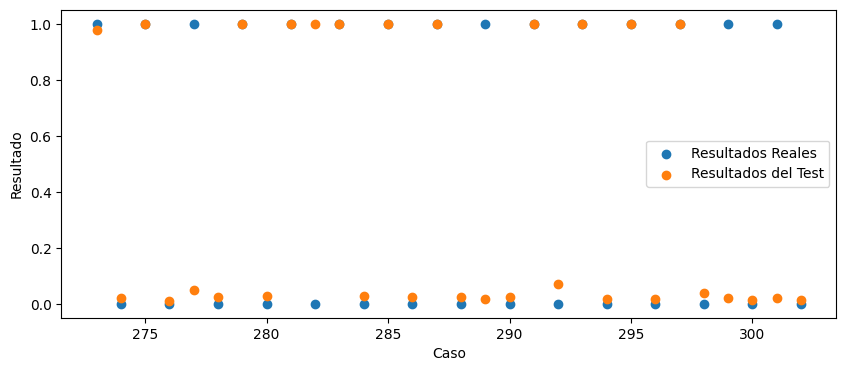

In [47]:
modelo, history = compilaModelo(tercerModelo, xTrain_normalized, yTrain_normalized, xValid_normalized, yValid_normalized, False)
evaluaEntrena(history)
resultadoTest = pruebaModelo(modelo, xTest_normalized, yTest_normalized)

#### Análisis de datos: ¿Probabilidad de Sufrir?
Si los resultados sobrepasan el 65%, diremos que SI son propensos a sufrir ataques cardíacos. De lo contario, diremos que NO son propensos.


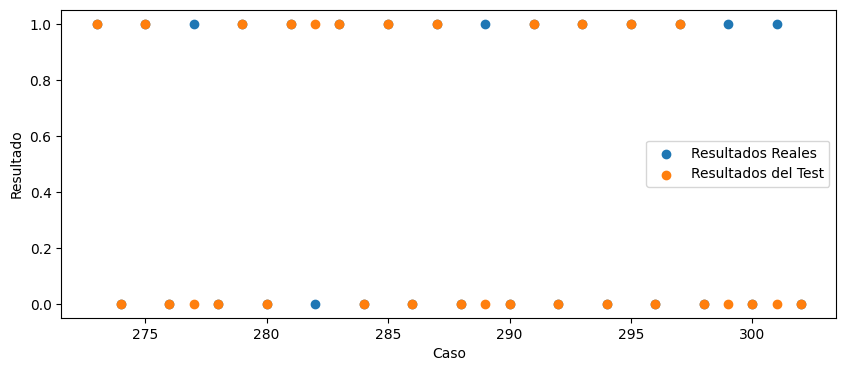

In [48]:
testResultAdjust = ajustaTest(resultadoTest)

Visualizando resultados con una matriz de confusión:

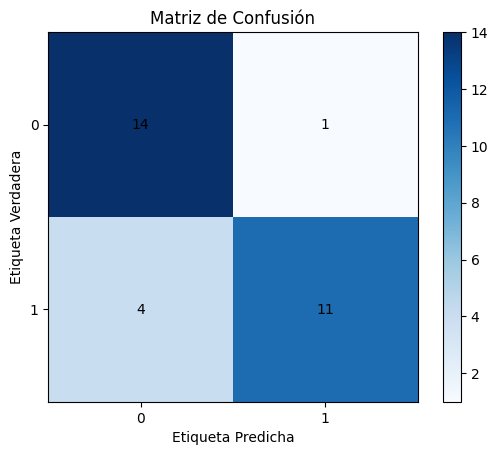

In [49]:
exactitudPrueba = matConf(testResultAdjust)

### Resumen de los Resultados

In [50]:
resultados(history, exactitudPrueba)

###### Resultados en Entrenamiento ######
Pérdida:
0.053
Exactitud:
98.901%

###### Resultados en Validación ######
Exactitud:
81.319%

###### Resultados en Pruebas ######
Exactitud:
83.333%


---
## Cuarto Modelo
* 6 capas ocultas
* relu


Entrenamiento completado!


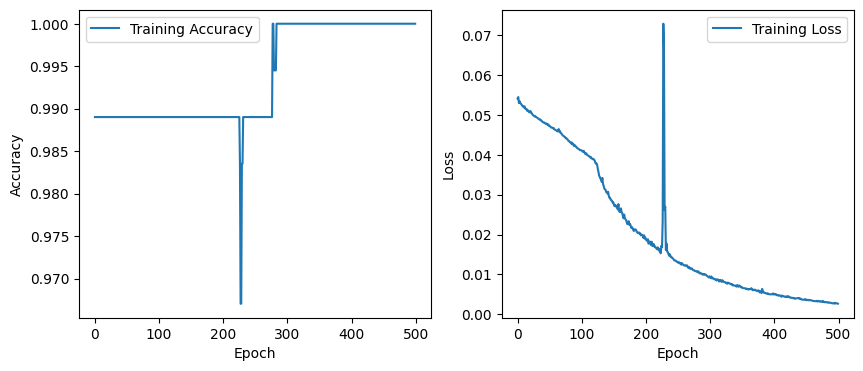

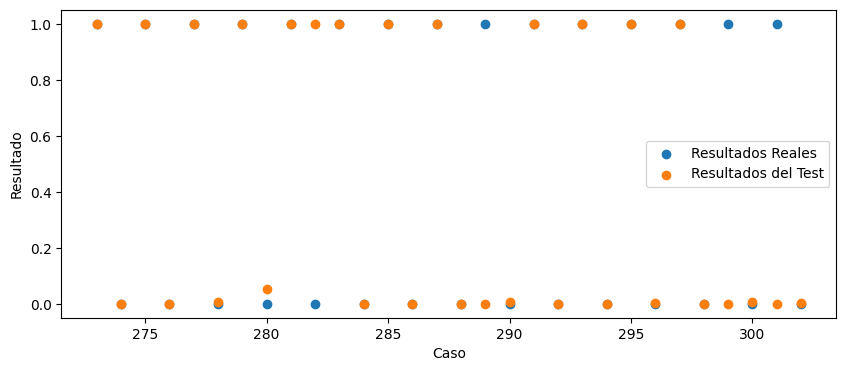

In [51]:
modelo, history = compilaModelo(tercerModelo, xTrain_normalized, yTrain_normalized, xValid_normalized, yValid_normalized, False)
evaluaEntrena(history)
resultadoTest = pruebaModelo(modelo, xTest_normalized, yTest_normalized)

#### Análisis de datos: ¿Probabilidad de Sufrir?
Si los resultados sobrepasan el 65%, diremos que SI son propensos a sufrir ataques cardíacos. De lo contario, diremos que NO son propensos.


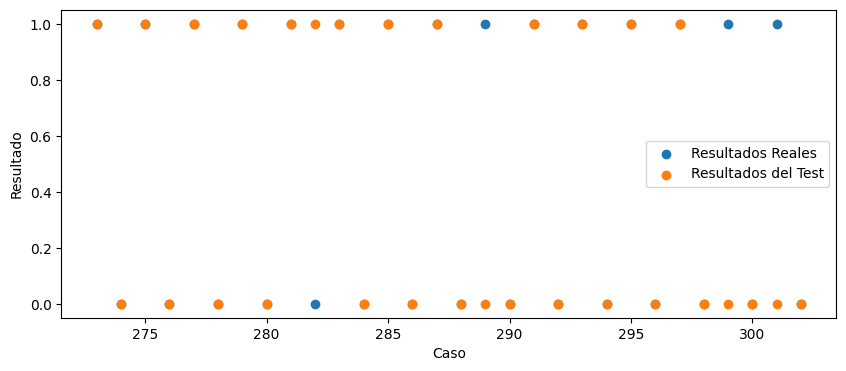

In [52]:
testResultAdjust = ajustaTest(resultadoTest)

Visualizando resultados con una matriz de confusión:

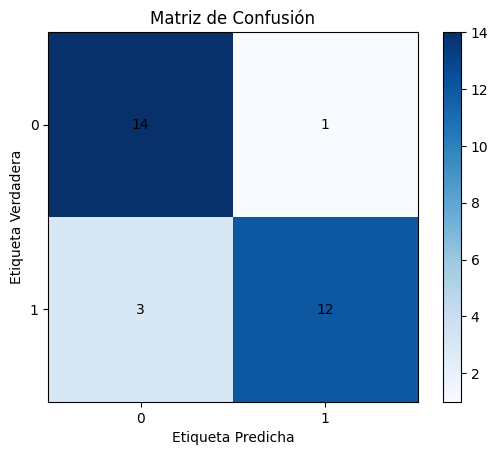

In [53]:
exactitudPrueba = matConf(testResultAdjust)

### Resumen de los Resultados

In [54]:
resultados(history, exactitudPrueba)

###### Resultados en Entrenamiento ######
Pérdida:
0.003
Exactitud:
100.0%

###### Resultados en Validación ######
Exactitud:
74.725%

###### Resultados en Pruebas ######
Exactitud:
86.667%


#Prueba framewok iaap

[Framework iaap](https://colab.research.google.com/drive/1DRiYk4Ir1uzjKSqmMf8pIKDfBEGkAMtr?usp=sharing)